In [27]:
# --- Libraries ---
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option("display.max_columns", None)


# Mapping the Socioeconomic Gradient of Diabetes in Canada

This project analyzes the prevalence of diabetes across Canadian provinces using **Statistics Canada’s Health Indicators (Table 13-10-0096-01)**.  
By combining official health data with geographic boundaries, the notebook visualizes regional inequalities in diabetes prevalence — a key dimension of Canada’s socioeconomic health gradient.


In [28]:
#Load and Inspect Raw Dataset

with open("13100096.csv", "r", encoding="utf-8") as f:
    lines = f.readlines()

# Header starts at the first line (0) since the CSV is cleanly structured in French
df = pd.read_csv("13100096.csv", sep=";", encoding="utf-8", quotechar='"')

print("✅ Dataset loaded successfully:", df.shape)
print("✅ Columns:", df.columns.tolist())
df.head()



✅ Dataset loaded successfully: (327165, 18)
✅ Columns: ['PÉRIODE DE RÉFÉRENCE', 'GÉO', 'DGUID', "Groupe d'âge", 'Sexe', 'Indicateurs', 'Caractéristiques', 'UNITÉ DE MESURE', "IDENTIFICATEUR D'UNITÉ DE MESURE", 'FACTEUR SCALAIRE', 'IDENTIFICATEUR SCALAIRE', 'VECTEUR', 'COORDONNÉES', 'VALEUR', 'STATUS', 'SYMBOLE', 'TERMINÉ', 'DÉCIMALES']


/tmp/ipython-input-227781852.py:7: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("13100096.csv", sep=";", encoding="utf-8", quotechar='"')


,PÉRIODE DE RÉFÉRENCE,GÉO,DGUID,Groupe d'âge,Sexe,Indicateurs,Caractéristiques,UNITÉ DE MESURE,IDENTIFICATEUR D'UNITÉ DE MESURE,FACTEUR SCALAIRE,IDENTIFICATEUR SCALAIRE,VECTEUR,COORDONNÉES,VALEUR,STATUS,SYMBOLE,TERMINÉ,DÉCIMALES
0,2015,Canada (sauf les territoires),NaN,"Total, 12 ans et plus",Les deux sexes,"Santé perçue, très bonne ou excellente",Nombre de personnes,Nombre,223,unités,0,v110787543,1.1.1.1.1,18759800.0,NaN,NaN,NaN,0
1,2015,Canada (sauf les territoires),NaN,"Total, 12 ans et plus",Les deux sexes,"Santé perçue, très bonne ou excellente",Limite inférieure de l'intervalle de confiance...,Nombre,223,unités,0,v110787544,1.1.1.1.2,18556100.0,NaN,NaN,NaN,0
2,2015,Canada (sauf les territoires),NaN,"Total, 12 ans et plus",Les deux sexes,"Santé perçue, très bonne ou excellente",Limite supérieure de l'intervalle de confiance...,Nombre,223,unités,0,v110787545,1.1.1.1.3,18963600.0,NaN,NaN,NaN,0
3,2015,Canada (sauf les territoires),NaN,"Total, 12 ans et plus",Les deux sexes,"Santé perçue, très bonne ou excellente",Pourcentage,Pourcent,239,unités,0,v110787546,1.1.1.1.4,61.9,NaN,NaN,NaN,1
4,2015,Canada (sauf les territoires),NaN,"Total, 12 ans et plus",Les deux sexes,"Santé perçue, très bonne ou excellente",Limite inférieure de l'intervalle de confiance...,Pourcent,239,unités,0,v110787547,1.1.1.1.5,61.3,NaN,NaN,NaN,1


In [29]:
# Standardize Column Names and Prepare Dataset

# Rename French columns to English equivalents for easier use
df = df.rename(columns={
    "PÉRIODE DE RÉFÉRENCE": "REF_DATE",
    "GÉO": "Geography",
    "Groupe d'âge": "Age group",
    "Sexe": "Sex",
    "Indicateurs": "Indicators",
    "Caractéristiques": "Characteristics",
    "VALEUR": "Value"
})

# Confirm rename worked
print("✅ Columns after renaming:", df.columns.tolist())

# Identify the latest year
latest_year = df["REF_DATE"].max()
print(f"✅ Latest year in dataset: {latest_year}")

# Filter for Diabetes indicator
df_diabetes = df[df["Indicators"].str.contains("Diab", case=False, na=False)].copy()
print("✅ Filtered diabetes records:", df_diabetes.shape)

# Show preview
df_diabetes.head()


✅ Columns after renaming: ['REF_DATE', 'Geography', 'DGUID', 'Age group', 'Sex', 'Indicators', 'Characteristics', 'UNITÉ DE MESURE', "IDENTIFICATEUR D'UNITÉ DE MESURE", 'FACTEUR SCALAIRE', 'IDENTIFICATEUR SCALAIRE', 'VECTEUR', 'COORDONNÉES', 'Value', 'STATUS', 'SYMBOLE', 'TERMINÉ', 'DÉCIMALES']
✅ Latest year in dataset: 2022
✅ Filtered diabetes records: (12591, 18)


,REF_DATE,Geography,DGUID,Age group,Sex,Indicators,Characteristics,UNITÉ DE MESURE,IDENTIFICATEUR D'UNITÉ DE MESURE,FACTEUR SCALAIRE,IDENTIFICATEUR SCALAIRE,VECTEUR,COORDONNÉES,Value,STATUS,SYMBOLE,TERMINÉ,DÉCIMALES
54,2015,Canada (sauf les territoires),NaN,"Total, 12 ans et plus",Les deux sexes,Diabète,Nombre de personnes,Nombre,223,unités,0,v110787606,1.1.1.10.1,2077300.0,NaN,NaN,NaN,0
55,2015,Canada (sauf les territoires),NaN,"Total, 12 ans et plus",Les deux sexes,Diabète,Limite inférieure de l'intervalle de confiance...,Nombre,223,unités,0,v110787607,1.1.1.10.2,1973100.0,NaN,NaN,NaN,0
56,2015,Canada (sauf les territoires),NaN,"Total, 12 ans et plus",Les deux sexes,Diabète,Limite supérieure de l'intervalle de confiance...,Nombre,223,unités,0,v110787608,1.1.1.10.3,2181500.0,NaN,NaN,NaN,0
57,2015,Canada (sauf les territoires),NaN,"Total, 12 ans et plus",Les deux sexes,Diabète,Pourcentage,Pourcent,239,unités,0,v110787609,1.1.1.10.4,6.9,NaN,NaN,NaN,1
58,2015,Canada (sauf les territoires),NaN,"Total, 12 ans et plus",Les deux sexes,Diabète,Limite inférieure de l'intervalle de confiance...,Pourcent,239,unités,0,v110787610,1.1.1.10.5,6.5,NaN,NaN,NaN,1


In [30]:
# Filter latest Diabetes prevalence data

# Get latest year
latest_year = df["REF_DATE"].max()

# Filter for Diabetes data (using French equivalents)
df_sub = df[
    (df["Indicators"].str.contains("Diab", case=False, na=False)) &
    (df["Sex"].isin(["Les deux sexes", "Both sexes"])) &
    (df["Age group"].isin(["Total, 12 ans et plus", "Total, 12 years and over"])) &
    (df["REF_DATE"] == latest_year) &
    (df["Characteristics"].str.contains("Pourcentage", case=False, na=False))
][["Geography", "Value"]].rename(columns={"Geography": "Province", "Value": "Prevalence"})

# Remove national totals
df_sub = df_sub[~df_sub["Province"].str.contains("Canada", case=False, na=False)]

print(f"✅ Data filtered for {latest_year}")
print("✅ Provinces found:", df_sub["Province"].tolist())
display(df_sub.head())


✅ Data filtered for 2022
✅ Provinces found: ['Terre-Neuve-et-Labrador', 'Terre-Neuve-et-Labrador', 'Terre-Neuve-et-Labrador', 'Île-du-Prince-Édouard', 'Île-du-Prince-Édouard', 'Île-du-Prince-Édouard', 'Nouvelle-Écosse', 'Nouvelle-Écosse', 'Nouvelle-Écosse', 'Nouveau-Brunswick', 'Nouveau-Brunswick', 'Nouveau-Brunswick', 'Québec', 'Québec', 'Québec', 'Ontario', 'Ontario', 'Ontario', 'Manitoba', 'Manitoba', 'Manitoba', 'Saskatchewan', 'Saskatchewan', 'Saskatchewan', 'Alberta', 'Alberta', 'Alberta', 'Colombie-Britannique', 'Colombie-Britannique', 'Colombie-Britannique']


,Province,Prevalence
277720,Terre-Neuve-et-Labrador,12.4
277721,Terre-Neuve-et-Labrador,10.6
277722,Terre-Neuve-et-Labrador,14.5
282672,Île-du-Prince-Édouard,8.9
282673,Île-du-Prince-Édouard,6.2


In [31]:
# Load a stable provincial shapefile (GeoJSON format)
!wget -q -O canada_provinces.geojson https://raw.githubusercontent.com/codeforgermany/click_that_hood/master/public/data/canada.geojson

canada_map = gpd.read_file("canada_provinces.geojson")

print("✅ Loaded provincial GeoJSON successfully.")
print("Sample provinces:", canada_map['name'].unique()[:10])


✅ Loaded provincial GeoJSON successfully.
Sample provinces: ['Quebec' 'Newfoundland and Labrador' 'British Columbia' 'Nunavut'
 'Northwest Territories' 'New Brunswick' 'Nova Scotia' 'Saskatchewan'
 'Alberta' 'Prince Edward Island']


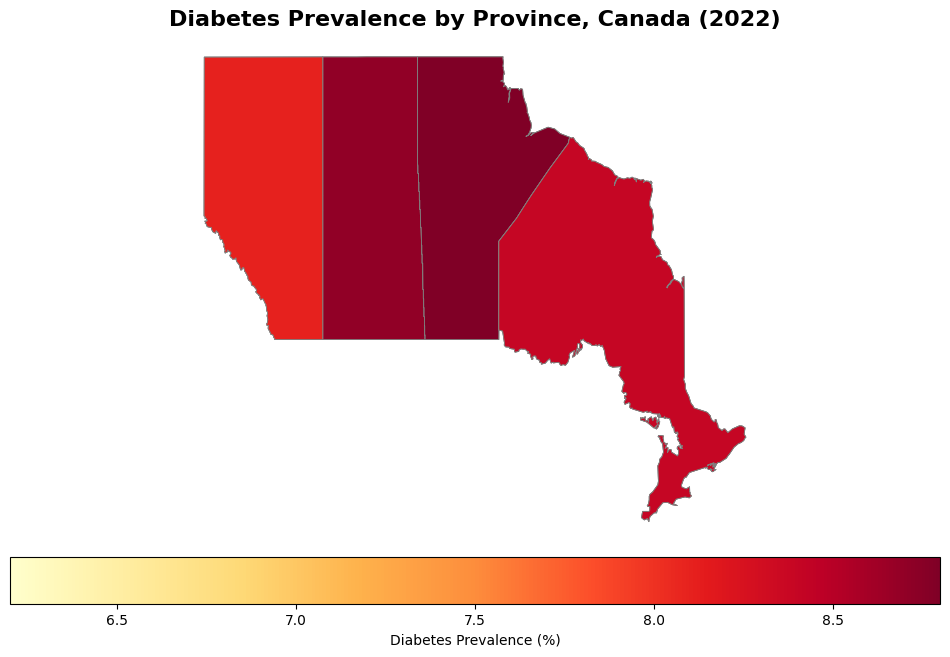

In [32]:
# Merge shapefile and diabetes data
merged = canada_map.merge(df_sub, how="left", left_on="name", right_on="Province")

# Plot choropleth map
fig, ax = plt.subplots(figsize=(12, 8))
merged.plot(
    column="Prevalence",
    cmap="YlOrRd",
    linewidth=0.6,
    edgecolor="grey",
    legend=True,
    legend_kwds={
        "label": "Diabetes Prevalence (%)",
        "orientation": "horizontal",
        "pad": 0.02
    },
    ax=ax
)
ax.set_title(f"Diabetes Prevalence by Province, Canada ({latest_year})", fontsize=16, weight="bold")
ax.axis("off")
plt.show()


In [33]:
# Quick overview of prevalence levels
print("Mean prevalence:", round(df_sub["Prevalence"].mean(), 2))
print("Standard deviation:", round(df_sub["Prevalence"].std(), 2))
print("Range:", (df_sub["Prevalence"].min(), df_sub["Prevalence"].max()))



Mean prevalence: 8.64
Standard deviation: 2.08
Range: (6.2, 14.5)


### Interpretation

The choropleth map illustrates diabetes prevalence across Canadian provinces in 2022.  
Rates are generally higher in Atlantic Canada and Newfoundland and Labrador, and lower in western provinces like British Columbia.  
This east–west gradient reflects underlying socioeconomic, lifestyle, and healthcare access disparities within Canada’s population.
